#DEPENDENCIES
---
---

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings("ignore")

#EXECUTION
---
---

In [94]:
# Lectura de los datos
df = pd.read_csv('data_final.csv', sep='|')

In [95]:
df.shape

(1320, 22)

In [96]:
df.dtypes

Fecha_prueba     object
Matricula        object
Temp_Amb        float64
Humr_Amb        float64
Marca            object
Modelo            int64
Cilindraje        int64
Combustible      object
Kilometraje     float64
Fecha_ITV        object
CDA              object
Temp_motor      float64
RPM_motor         int64
HC                int64
CO              float64
CO2             float64
O2              float64
RPM_Cru           int64
HC_Cru            int64
CO_Cru          float64
CO2_Cru         float64
O2_Cru          float64
dtype: object

In [97]:
# Conversion de las columnas a Datetime
df['Fecha_prueba'] = pd.to_datetime(df['Fecha_prueba'])
df['Fecha_ITV'] = pd.to_datetime(df['Fecha_ITV'])

In [98]:
# Generación de nuevos features de utilidad a partir de las columnas de tipo Datetime
df = df.assign(Dias_ITV=lambda x: (x['Fecha_prueba']-x['Fecha_ITV']))
df['Dias_ITV'] = df['Dias_ITV'].apply(lambda x: x.days)

df = df.assign(Anos=lambda x: (x['Fecha_prueba'].dt.year-x['Modelo']))

df.shape

(1320, 24)

In [99]:
df.head(5)

,Fecha_prueba,Matricula,Temp_Amb,Humr_Amb,Marca,Modelo,Cilindraje,Combustible,Kilometraje,Fecha_ITV,...,CO,CO2,O2,RPM_Cru,HC_Cru,CO_Cru,CO2_Cru,O2_Cru,Dias_ITV,Anos
0,2021-08-13 10:47:46,4231 JWJ,26.5,36.1,MARCA 1,1998,4300,GNV,11977.5,2021-08-11,...,2.57,9.60,1.40,2640,53,0.11,10.82,2.10,2,23
1,2021-08-13 11:21:09,1651 RBK,23.5,41.5,MARCA 4,2007,999,GNV_gasolina,56456.0,2020-08-14,...,1.05,13.70,0.85,2710,197,0.98,13.70,0.95,364,14
2,2021-08-13 11:59:04,1683 SRF,21.3,44.4,MARCA 2,2008,999,GNV_gasolina,784516.0,2021-07-10,...,0.81,11.27,0.76,2410,110,0.11,9.85,3.76,34,13
3,2021-08-13 12:15:04,6997 CXW,19.2,60.9,MARCA 5,2012,1493,GNV_gasolina,6984.0,2021-06-10,...,1.25,12.45,2.49,2410,226,1.53,12.19,2.61,64,9
4,2021-08-13 12:36:23,6344 SJD,23.6,41.6,MARCA 2,2005,999,GNV_gasolina,766819.0,2020-12-03,...,1.19,9.70,2.56,2250,172,0.72,9.43,3.65,253,16


In [100]:
#Eliminación de los features poco relevantes en el análisis
df.drop(list(df[df['Dias_ITV']<0].index), axis=0, inplace=True)

df.drop(['Fecha_prueba', 'Matricula', 'Temp_Amb', 'Humr_Amb', 'Modelo',
         'Cilindraje', 'Kilometraje', 'Fecha_ITV', 'Temp_motor', 'RPM_motor',
         'RPM_Cru'], axis=1, inplace=True)

df.shape

(1294, 13)

In [101]:
df.columns

Index(['Marca', 'Combustible', 'CDA', 'HC', 'CO', 'CO2', 'O2', 'HC_Cru',
       'CO_Cru', 'CO2_Cru', 'O2_Cru', 'Dias_ITV', 'Anos'],
      dtype='object')

In [102]:
# División y procesamiento de las variables de tipo numérico y categórico del dataset 
df_cat = df[['Marca', 'Combustible', 'CDA']]
df_cat = pd.get_dummies(df_cat, prefix_sep='.')

df_num = df[['HC', 'CO', 'CO2', 'O2', 'HC_Cru', 'CO_Cru', 'CO2_Cru', 'O2_Cru', 'Dias_ITV', 'Anos']]
df_num = pd.DataFrame(StandardScaler().fit_transform(df_num), index=df_num.index, columns=df_num.columns)

df_proc = pd.concat([df_num, df_cat], axis=1)
df_proc.shape

(1294, 31)

#CLUSTERING KMeans

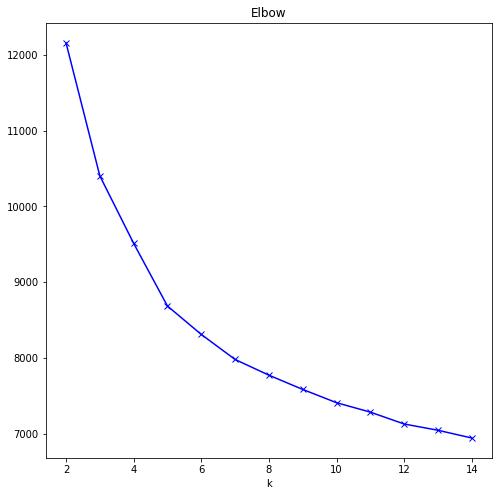

In [103]:
sum_of_squared_distances = []
silhouette_scores = []

K = range(2,15)
for k in K: 
    km = KMeans(n_clusters=k)
    km = km.fit(df_proc)
    sum_of_squared_distances.append(km.inertia_)

    y = km.predict(df_proc)
    silhouette_scores.append(silhouette_score(df_proc,y))

plt.figure(figsize=(8,8))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.title('Elbow')
plt.xlabel('k')
plt.show()

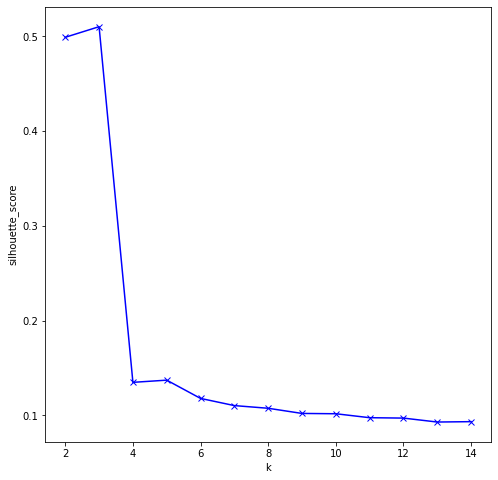

In [104]:
plt.figure(figsize=(8,8))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.show()

In [105]:
km = KMeans(n_clusters=3)
y_kmeans = km.fit_predict(df_proc)

#CLUSTERING Hierarchical

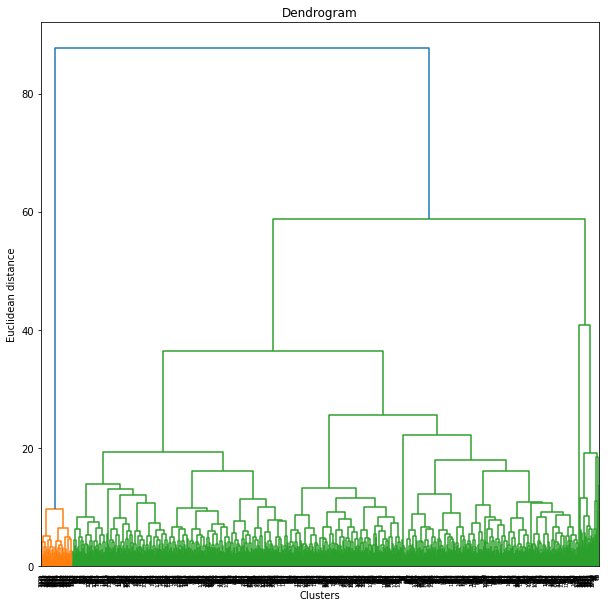

In [106]:
fig = plt.figure(figsize=(10,10))
dendrogram_plot = dendrogram(linkage(df_proc, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Clusters')
plt.ylabel('Euclidean distance')
plt.show()

In [107]:
hc = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
y_hc = hc.fit_predict(df_proc)

#CLUSTERING DBSCAN

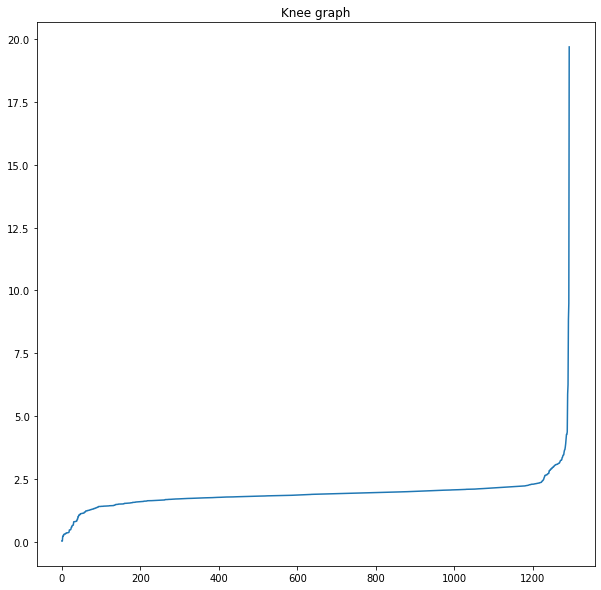

In [108]:
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(df_proc)
distances, indices = neighbors_fit.kneighbors(df_proc)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

fig = plt.figure(figsize=(10,10))
plt.plot(distances)
plt.title('Knee graph')
plt.show()

In [109]:
eps = np.arange(2, 3.5 , 0.1)
min_samples = np.arange(3, 12)

from itertools import product

dbscan_paramns = list(product(eps, min_samples))
n_cluster = []
sil_scores = []

for p in dbscan_paramns: 
    y_dbscan = DBSCAN(eps= p[0], min_samples=p[1]).fit_predict(df_proc)
    try:
        sil_scores.append(silhouette_score(df_proc, y_dbscan))
    except:
        sil_scores.append(0)
    n_cluster.append(len(np.unique(y_dbscan)))  

df_param_tuner = pd.DataFrame.from_records(dbscan_paramns, columns=['eps', 'Min_samples'])
df_param_tuner['sil_scores'] = sil_scores
df_param_tuner['n_clusters'] = n_cluster

pivot_1 = pd.pivot_table(df_param_tuner, values='sil_scores',index='Min_samples',columns='eps')
pivot_2 = pd.pivot_table(df_param_tuner, values='n_clusters',index='Min_samples',columns='eps')

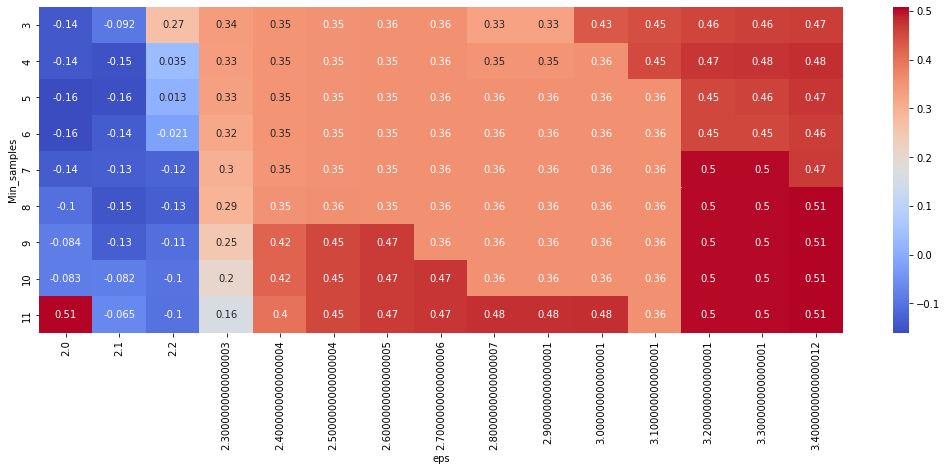

In [110]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.heatmap(pivot_1, annot=True, annot_kws={'size':10}, cmap='coolwarm', ax=ax)

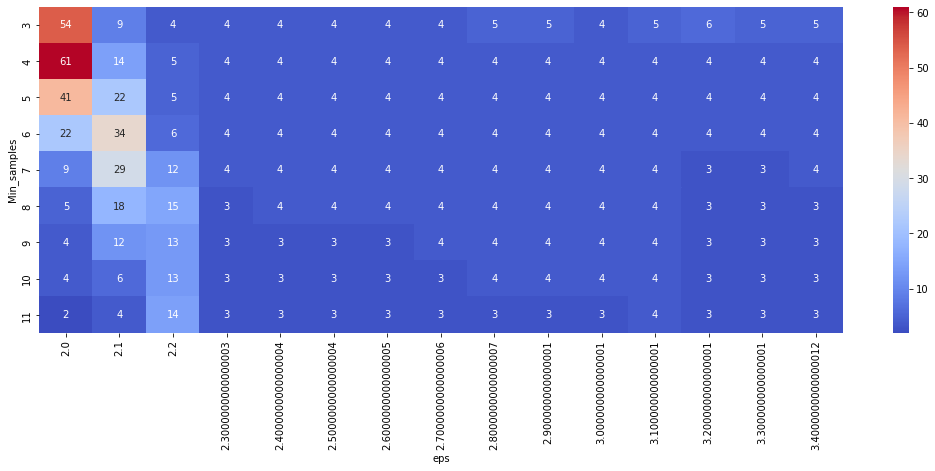

In [111]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.heatmap(pivot_2, annot=True, annot_kws={'size':10}, cmap='coolwarm', ax=ax)

In [112]:
dbscan_train = DBSCAN(eps= 3.4, min_samples=4)
y_dbscan = dbscan_train.fit_predict(df_proc)

#RESULTS
---
---

In [113]:
# Tabla con los resultados de los métodos de cluster
pd.DataFrame([[silhouette_score(df_proc,y_kmeans), 3], [silhouette_score(df_proc,y_hc), 4], [silhouette_score(df_proc,y_dbscan), 4]],
             index=['Kmeans', 'Hierarchical', 'DBScan'], columns=['Silhouette index', 'Num clusters'])

,Silhouette index,Num clusters
Kmeans,0.510165,3
Hierarchical,0.499693,4
DBScan,0.480074,4


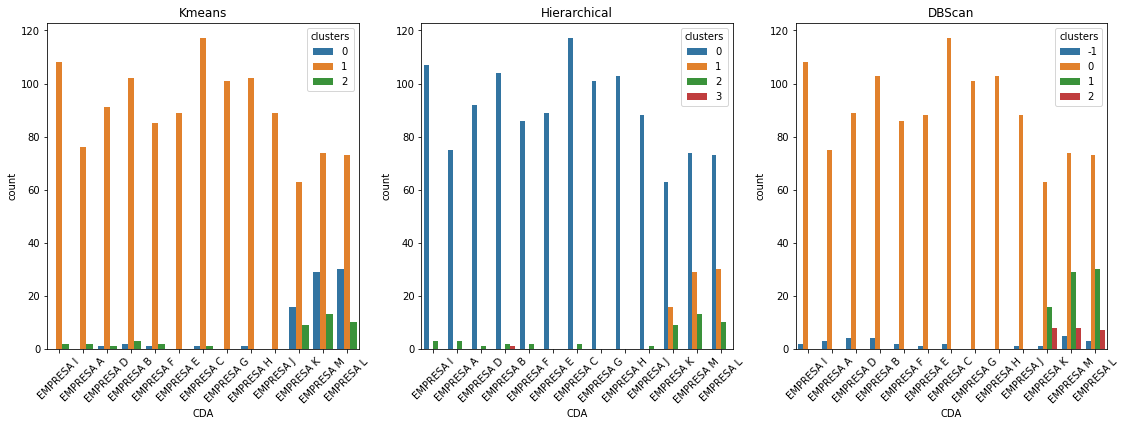

In [114]:
# Gráfico de los resultados
methods = [y_kmeans, y_hc, y_dbscan]
name = ['Kmeans', 'Hierarchical', 'DBScan']
plt.figure(figsize=(19,6))
for x in enumerate(methods):
    df['clusters'] = x[1]    
    plt.subplot(1, 3, x[0]+1)
    sns.countplot(data=df, x='CDA', hue='clusters')
    plt.xticks(rotation=45)
    plt.title(name[x[0]])

In [115]:
df[df['CDA']=='EMPRESA K'][df['clusters']==2]

,Marca,Combustible,CDA,HC,CO,CO2,O2,HC_Cru,CO_Cru,CO2_Cru,O2_Cru,Dias_ITV,Anos,clusters
1284,MARCA 2,Gasolina,EMPRESA K,107,1.20,17.7,3.2,213,0.81,19.6,3.6,5,14,2
1286,MARCA 3,GNV_gasolina,EMPRESA K,120,0.81,25.2,3.9,212,0.64,21.9,2.9,9,3,2
1289,MARCA 2,Gasolina,EMPRESA K,127,1.11,21.6,2.8,234,1.15,24.0,3.0,125,8,2
1294,MARCA 1,Gasolina,EMPRESA K,138,0.51,22.0,2.6,239,1.41,25.0,2.8,59,7,2
1299,MARCA 2,GNV,EMPRESA K,237,0.51,23.1,3.4,233,1.06,19.5,2.6,4,8,2
1301,MARCA 3,GNV,EMPRESA K,146,0.51,21.0,1.0,210,0.57,19.5,3.1,10,9,2
1302,MARCA 5,GNV_gasolina,EMPRESA K,240,0.81,19.9,1.5,209,0.74,16.8,3.1,46,13,2
1303,MARCA 4,GNV,EMPRESA K,159,0.53,17.4,3.2,210,0.68,23.1,3.7,129,10,2


Se puede concluir que la EMPRESA K, EMPRESA L y EMPRESA M presentan irregularidades en sus resultados, por ende deben ser sometidas a un proceso de auditoria por el órgano de control al que esten sometidas en pro de mejorar la calidad del aire en la ciudad.